<div style="text-align:center;color:Blue">
    <h2> Graph Regression with Graph Neural Networks</h2>
</div>

#### This notebook presents a thorough approach on how to apply Graph Neural Networks (GNNs) to solve a graph regression problem. 

We apply graph regression to assign one y-value to an entire graph (in contrast to nodes). 
1. We start with a dataset of graphs, based on some structural graph properties - in today's case based on lipophilicity.
2. Accordingly, entire graphs are embedded in such a way that helps us predict a molecular property prediction (a single 
lipophilicity value) for each. One can use these embeddings further to do more analysis, such as 
to classify them based on a value, such as a lipophilicity range.

Play with the model settings, data splitting, training setups etc. to get the best results from this code and any other data/model you implement based on the information provided.

#### The data: Experimental results of octanol/water distribution coefficient (logD at pH 7.4). 
Lipophilicity is an important feature of drug molecules that affects both membrane permeability 
and solubility - thus a molecule's interactivity with other molecules. 

1.	Import lipophilicity data for 4000 molecules (https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv, or use Python)
2. from PyTorch Geometric’s dataset library (https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)
   
This Lipophilicity dataset is curated from ChEMBL database, provides experimental results of 
octanol/water distribution coefficient (logD at pH 7.4) of 4200 compounds. 
Read more: https://arxiv.org/pdf/1703.00564.pdf

In [8]:
from pandas.plotting import table
from rdkit.Chem import Draw
from rdkit import Chem
from sklearn.metrics import r2_score
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import to_networkx
from torch.nn import Linear
  
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pubchempy
import rdkit
import time
import torch
import torch.nn.functional as F 
import warnings
warnings.filterwarnings("ignore")

<div style="text-align:center;color:Blue">
    <h3> Lipophilicty dataset import (load if already imported) and explore</h3>
</div>

In [9]:
dataset = MoleculeNet(root=".", name="lipo")
data = dataset[0]

In [10]:
print('\n======== Dataset =======\n')
print("Dataset type: ", type(dataset))
print("Dataset size (graphs): ", len(dataset))
print("Dataset features: ", dataset.num_features)
print("Dataset target: ", dataset.num_classes)
print("Dataset length: ", dataset.len)
print('\n======== first sample =======\n')
print("Dataset sample: ", data)
print("Sample  nodes: ", data.num_nodes)
print("Sample  edges: ", data.num_edges)


======== Dataset =======

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset size (graphs):  4200
Dataset features:  9
Dataset target:  553
Dataset length:  <bound method InMemoryDataset.len of Lipophilicity(4200)>

======== first sample =======

Dataset sample:  Data(x=[24, 9], edge_index=[2, 54], edge_attr=[54, 3], smiles='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', y=[1, 1])
Sample  nodes:  24
Sample  edges:  54


In [11]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

# Function to compute molecular descriptors from SMILES
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Return None for invalid SMILES
    return {
        "MolecularWeight": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
        "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
        "NumAromaticRings": Descriptors.NumAromaticRings(mol),
    }

# Load dataset (modify path accordingly)
df = pd.read_csv("/Users/sheenamittal/Desktop/work /My Projects/GNNs_drug_discovery_regression-gnn_main/lipo/raw/Lipophilicity.csv")  

# Compute descriptors for all molecules
df_descriptors = df["smiles"].apply(compute_descriptors).apply(pd.Series)

# Merge descriptors with original dataset
df = pd.concat([df, df_descriptors], axis=1)

# Save updated dataset
df.to_csv("Lipophilicity_with_descriptors.csv", index=False)
print("✅ Molecular descriptors added and saved!")


✅ Molecular descriptors added and saved!


In [12]:
# Load dataset (modify path if needed)
df = pd.read_csv("Lipophilicity_with_descriptors.csv")

# Display first few rows
print(df.head())

   CMPD_CHEMBLID   exp                                             smiles  \
0   CHEMBL596271  3.54            Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14   
1  CHEMBL1951080 -1.18  COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...   
2     CHEMBL1771  3.69             COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl   
3   CHEMBL234951  3.37  OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...   
4   CHEMBL565079  3.10  Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...   

   MolecularWeight    LogP    TPSA  NumHDonors  NumHAcceptors  \
0          340.858  3.5489   24.30         0.0            4.0   
1          494.591  2.9901  122.24         2.0            7.0   
2          321.829  3.6739   29.54         0.0            4.0   
3          419.890  1.9237  105.66         4.0            5.0   
4          381.480  2.0069   99.81         2.0            5.0   

   NumRotatableBonds  NumAromaticRings  
0                3.0               3.0  
1                9.0               2.0  
2                3.0   

### Feature Distributions

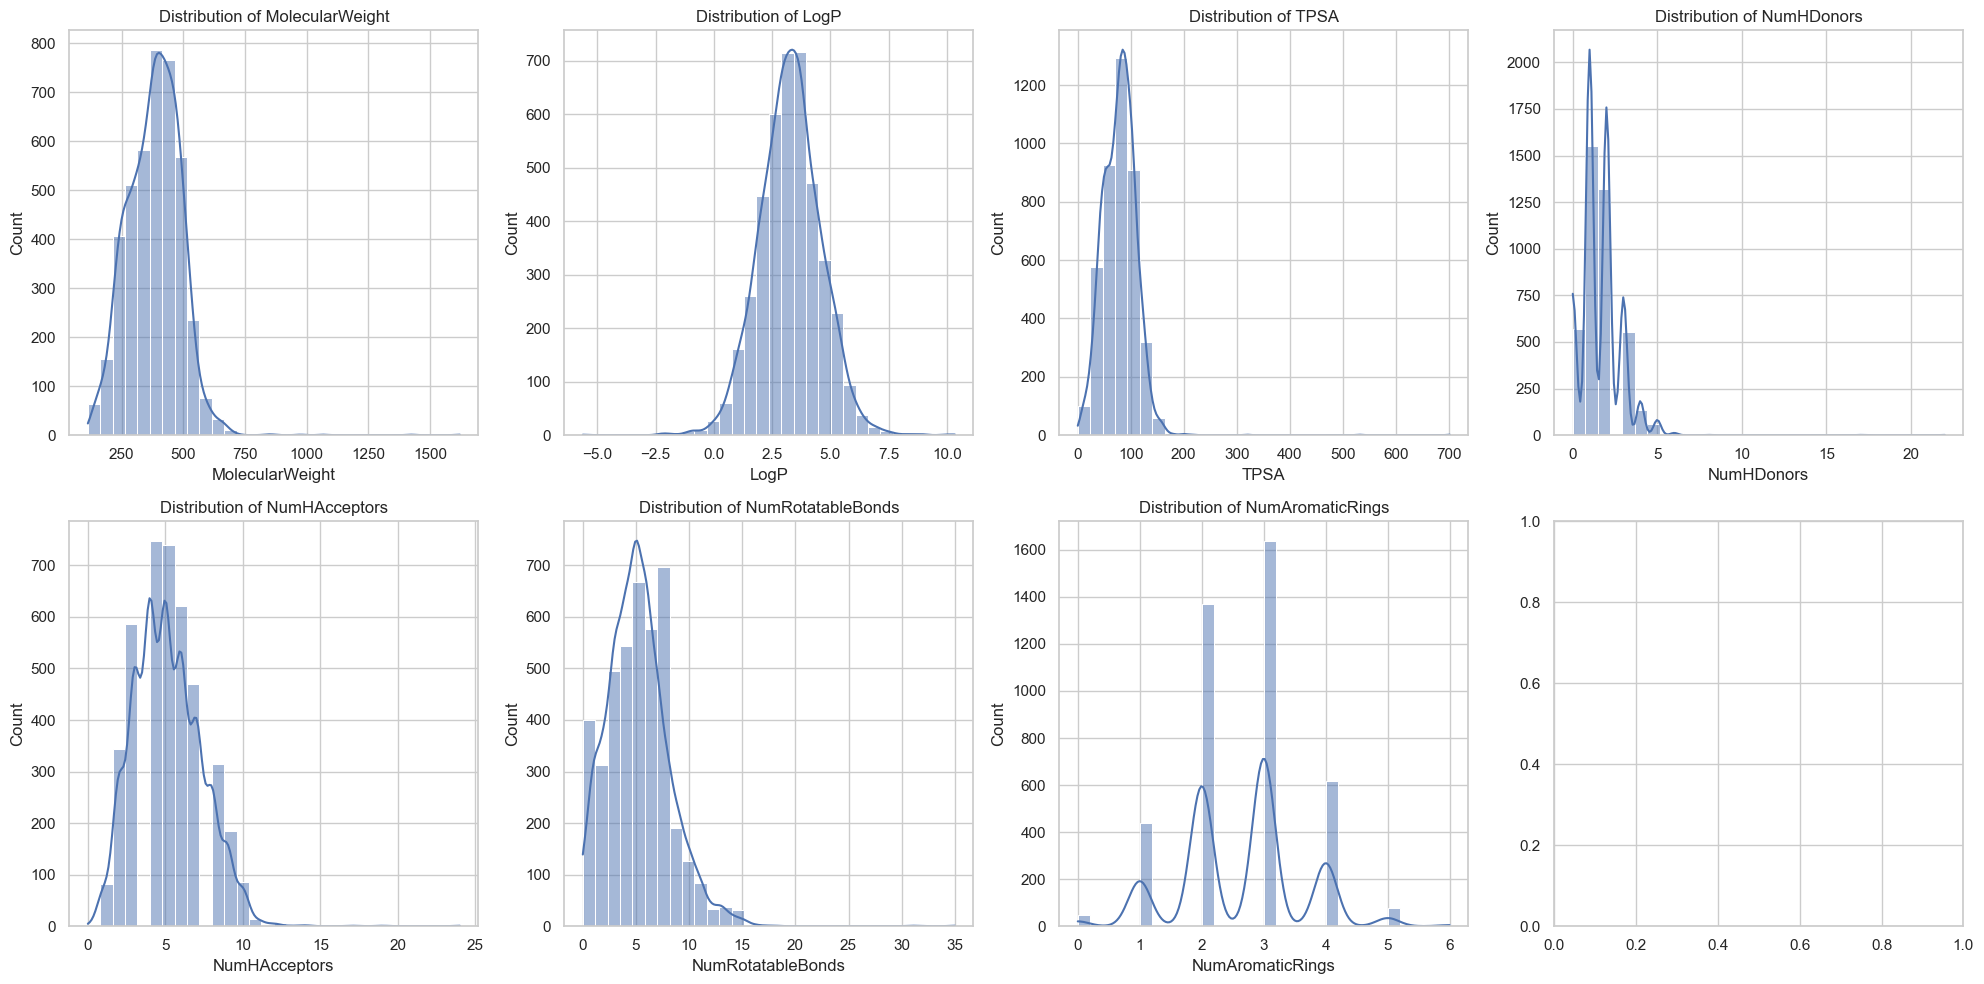

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# List of features to plot
features = ["MolecularWeight", "LogP", "TPSA", "NumHDonors", "NumHAcceptors", "NumRotatableBonds", "NumAromaticRings"]

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

# Plot each feature
for i, feature in enumerate(features):
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


### Correlation Analysis

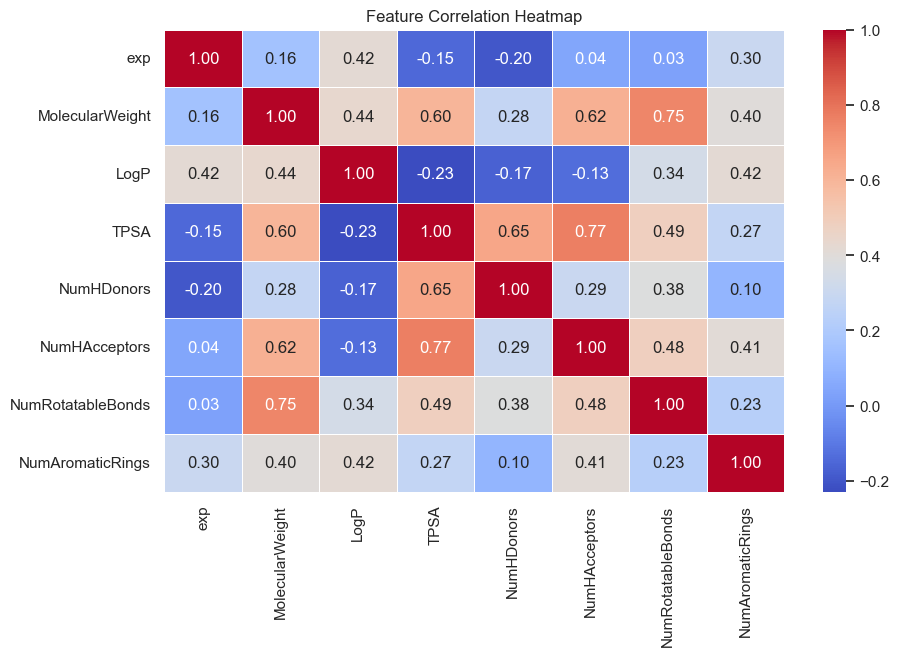

In [14]:
# Drop non-numeric columns
df_numeric = df.select_dtypes(include=["number"])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


### Identify important features

In [15]:
print(df.columns)


Index(['CMPD_CHEMBLID', 'exp', 'smiles', 'MolecularWeight', 'LogP', 'TPSA',
       'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds', 'NumAromaticRings'],
      dtype='object')


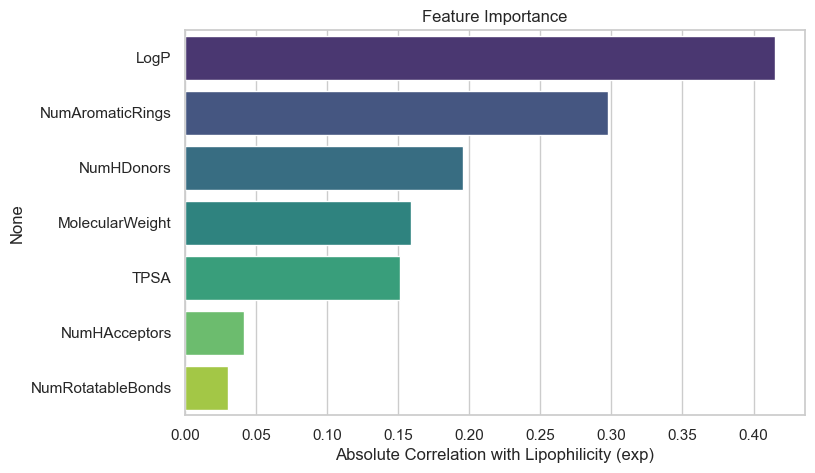

In [16]:
# Drop non-numeric columns
df_numeric = df.select_dtypes(include=["number"])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Sort features by correlation with lipophilicity (exp)
feature_importance = correlation_matrix["exp"].drop("exp").abs().sort_values(ascending=False)

# Plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.xlabel("Absolute Correlation with Lipophilicity (exp)")
plt.title("Feature Importance")
plt.show()


### Feature engineering (adding more features)

In [17]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv("/Users/sheenamittal/Desktop/work /My Projects/GNNs_drug_discovery_regression-gnn_main/lipo/raw/Lipophilicity.csv")

# Convert SMILES to RDKit Molecule objects
df["mol"] = df["smiles"].apply(Chem.MolFromSmiles)

# Function to compute RDKit descriptors
def compute_rdkit_features(mol):
    if mol is None:
        return {
            "MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumHDonors": np.nan,
            "NumHAcceptors": np.nan, "NumRotatableBonds": np.nan, "NumAromaticRings": np.nan
        }
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
        "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
        "NumAromaticRings": Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    }

# Compute RDKit descriptors
rdkit_features = df["mol"].apply(compute_rdkit_features).apply(pd.Series)

# Function to compute Morgan fingerprints
def compute_fingerprint(mol, radius=2, nBits=2048):
    if mol is None:
        return np.zeros(nBits)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits))

# Compute fingerprints
fingerprint_array = np.array(df["mol"].apply(compute_fingerprint).tolist())

# Convert fingerprints to DataFrame
fingerprint_df = pd.DataFrame(fingerprint_array, columns=[f"FP_{i}" for i in range(2048)])

# Merge all features into the DataFrame
df = pd.concat([df, rdkit_features, fingerprint_df], axis=1)

# Drop unnecessary columns
df.drop(["mol", "smiles"], axis=1, inplace=True)

# Separate numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=["number"]).columns

# Normalize numeric features
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Save processed data
df.to_csv("processed_data.csv", index=False)
print("Feature Engineering Complete! Data saved as 'processed_data.csv'.")

[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerator
[15:05:04] DEPRECATION WARNING: please use MorganGenerat

Feature Engineering Complete! Data saved as 'processed_data.csv'.


 <div style="text-align:left;color:Maroon">
    <h4> Take a look at the first 5 nodes from the first sample molecule</h4>
</div>

In [18]:
dataset[0].x[:5]

tensor([[6, 0, 4, 5, 3, 0, 4, 0, 0],
        [7, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [7, 0, 3, 5, 0, 0, 4, 0, 1]])

<div style="text-align:left;color:Maroon">
    <h4> The first 5 sparse matrices (COO)</h4>
</div>

In [19]:
dataset[0].edge_index.t()[:5]

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 1, 23],
        [ 2,  1]])

<div style="text-align:left;color:Maroon">
    <h4> The target (lipophilicty value for the first data point (i.e. molecule))</h4>
</div>

In [20]:
dataset[0].y

tensor([[3.5400]])

<div style="text-align:left;color:Maroon">
    <h4>Use pubchempy to get the name and rdkit to draw the first molecular structure</h4>
</div>

In [21]:
sm = dataset[0]['smiles']
compound = pubchempy.get_compounds(sm, namespace='smiles')
match = compound[0]
match.iupac_name

'2-[[4-(4-chlorophenyl)piperazin-1-yl]methyl]-1-methylbenzimidazole'

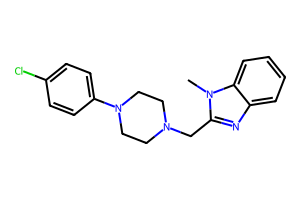

In [22]:
molecule = Draw.MolsToGridImage([Chem.MolFromSmiles(sm)], 
                molsPerRow=1, subImgSize=(300,200), returnPNG=False)
molecule.save('assets/images/first_molecule.png')
molecule

<div style="text-align:left;color:Maroon">
    <h4>Let's build a dataframe with some important attributes for each of the first 12 molecules. Twelve because it makes grid plotting easier. Here, we convert a tensor (the target, data.y) to an array for simplicity.</h4>
</div>

In [23]:
top_n = 12
data_attrib = []

for data in dataset[:top_n]:
    data_attrib.append([data.num_nodes, data.num_edges, data.smiles, np.array(data.y[0])[0]])
    
data_attr = pd.DataFrame(data_attrib)
data_attr.columns = ['num_nodes', 'num_edges', 'smiles', 'target_logD']
data_attr.head(top_n)

,num_nodes,num_edges,smiles,target_logD
0,24,54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54
1,33,70,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18
2,21,46,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69
3,28,62,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37
4,28,58,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10
5,23,52,OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4,3.14
6,35,74,COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccc...,-0.72
7,34,72,CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...,0.34
8,23,50,COc1ccc(cc1)C2=COc3cc(OC)cc(OC)c3C2=O,3.05
9,15,34,Oc1ncnc2scc(c3ccsc3)c12,2.25


<div style="text-align:left;color:Maroon">
    <h4>Next, we plot the molecular structure for the first 12 molecules. We use the package 'pubchempy' to convert smiles into chemical names. Then we shorten the names for visual clarity (in subplot titles and the above dataframe). To do so, we split the name and use the last string piece after the last ')' or ']', whichever is the shortest.</h4>
</div>

In [24]:
ch_names = []
for i in data_attr["smiles"]:
    compounds = pubchempy.get_compounds(i, namespace='smiles')
    match = compounds[0]
    names = [match.iupac_name.split(')')[-1], match.iupac_name.split(']')[-1]]
    res = min(names, key=len)
    ch_names.append(res)
chem_names = ['... ' + str(i) for i in ch_names]
data_attr["name"] = chem_names
data_attr

,num_nodes,num_edges,smiles,target_logD,name
0,24,54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54,... -1-methylbenzimidazole
1,33,70,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18,... sulfanylacetic acid
2,21,46,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69,... acetate
3,28,62,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37,... pyrrole-5-carboxamide
4,28,58,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10,... -2-methylpyrazole-3-carboxamide
5,23,52,OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4,3.14,... octan-3-ol
6,35,74,COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccc...,-0.72,... -4-oxobutanoic acid
7,34,72,CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...,0.34,... propanoic acid
8,23,50,COc1ccc(cc1)C2=COc3cc(OC)cc(OC)c3C2=O,3.05,... chromen-4-one
9,15,34,Oc1ncnc2scc(c3ccsc3)c12,2.25,... pyrimidin-4-one


<div style="text-align:left;color:Maroon">
    <h4>Save the dataframe as an image using a great python package called 'dataframe_image'</h4>
</div>

In [27]:
data_attr.to_csv("assets/data_attrib.csv", index=False)

In [31]:
import pandas as pd
import dataframe_image as dfi

# Load data from a CSV file
data_attr = pd.read_csv("/Users/sheenamittal/Downloads/GNNs_drug_discovery_regression-gnn_main/assets/data_attrib.csv")

# Apply styling and export
df_styled = data_attr.style.background_gradient()
dfi.export(df_styled, "assets/images/data_attrib.png", table_conversion='matplotlib')

<div style="text-align:left;color:Maroon">
    <h4>We are now ready to plot the 12 molecules</h4>
</div>

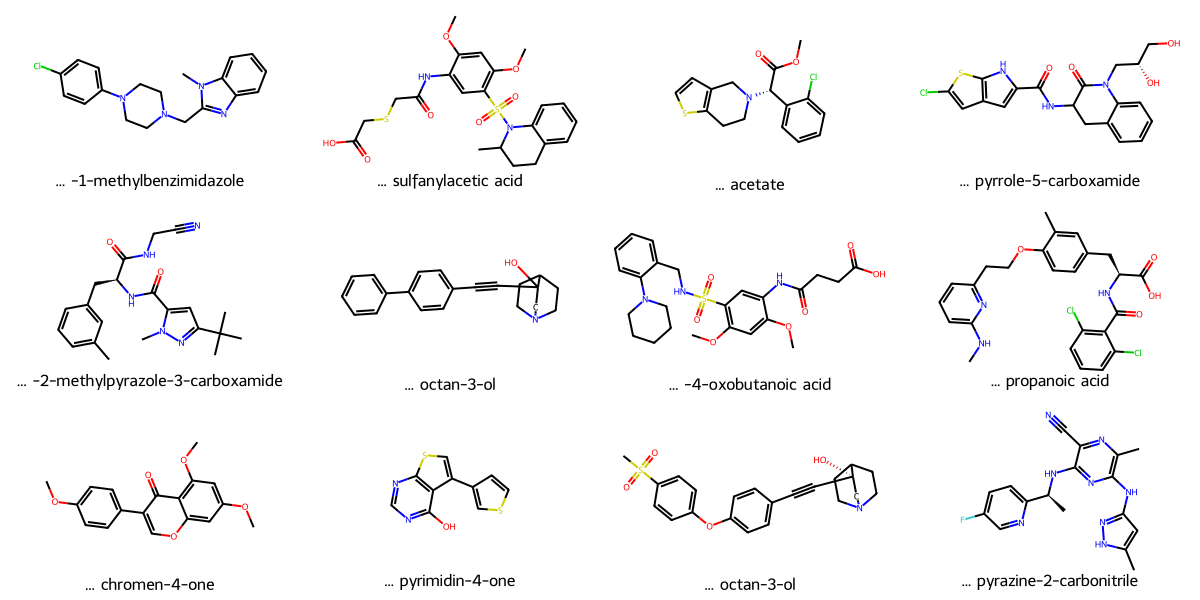

In [32]:
img = Draw.MolsToGridImage([Chem.MolFromSmiles(data_attr["smiles"][i]) for i in range(top_n)], 
                         molsPerRow=4,subImgSize=(300,200), legends=list(data_attr.name.values),
                         returnPNG=False)
img.save('assets/images/molecules.png')
img

<div style="text-align:left;color:Maroon">
    <h4>To visualize two of the graphs (the first and tenth graph from our original dataset), we convert PyTorch Geometric graph to to NetworkX. Note that there are 24 nodes in the first graph and 27 in the second.</h4>
</div>

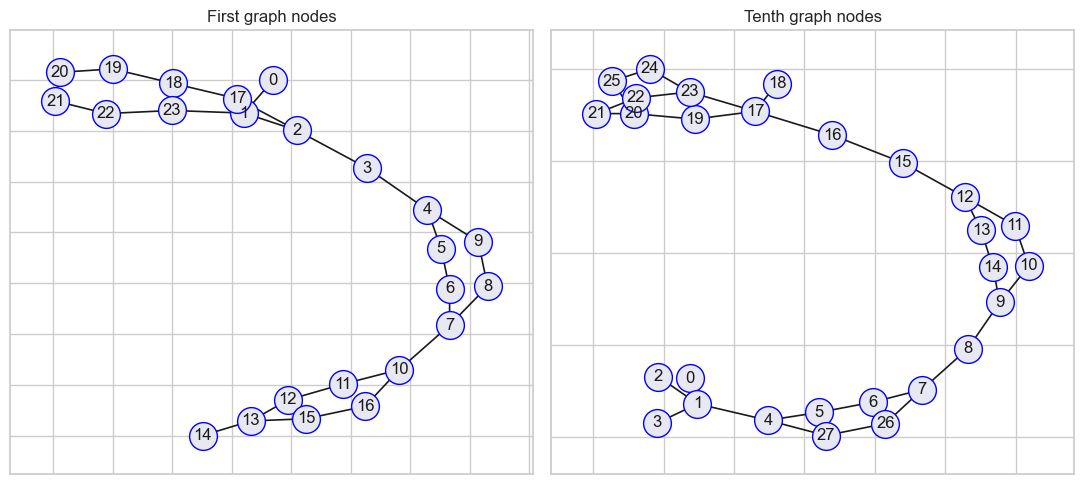

In [33]:
import matplotlib.pyplot as plt

def visualize_net():
    plt.figure(figsize=(11,5))
    ax1 = plt.subplot2grid(shape=(1, 2), loc=(0,0))
    ax2 = plt.subplot2grid(shape=(1, 2), loc=(0,1))
    ax1.set_title('First graph nodes')
    ax2.set_title('Tenth graph nodes')

    G = to_networkx(dataset[0], to_undirected=True)
    
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=14), with_labels=True,
                     node_color=[0.91, 0.91, 0.95], node_size=400, width=1.2,
                     edgecolors='blue', cmap="Set2", ax=ax1)
    
    G = to_networkx(dataset[10], to_undirected=True)
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=14), with_labels=True,
                    node_color=[0.91, 0.91, 0.95], node_size=400, width=1.2,
                    edgecolors='blue', cmap="Set2", ax=ax2)
    plt.tight_layout()
    plt.savefig('assets/images/graphs.png', bbox_inches='tight')
    plt.show()    
    
visualize_net()

<div style="text-align:center;color:Blue">
    <h3> Solubility regression with GNN</h3>
</div>

#### Steps: 
1. Create a GCN model structure that contains three GCNConv layers, and 64 hidden channels.  

2. Perform graph level (one y-value per graph) prediction

In [34]:
import torch.nn as nn

embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers with Dropout
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Dropout layers
        self.dropout = nn.Dropout(p=0.3)  

        # Output layer
        self.out = Linear(embedding_size * 2, 1)

    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)
        hidden = self.dropout(hidden)  

        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.dropout(hidden)  

        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.dropout(hidden)  

        hidden = self.conv3(hidden, edge_index)
        hidden = F.relu(hidden)

        # Global Pooling
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)

        # Linear layer
        out = self.out(hidden)

        return out, hidden

# Initialize model
model = GCN()

print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))


GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


<div style="text-align:center;color:Blue">
    <h3> Train the GNN</h3>
</div>

Here, we use sklearn's r2_score to measure performance to follow accuracy through time. As this is a regression problem, the right metric is RMSE, but for visual follow-up we calculate accuracy as it is the most intuitive metric. Training using 500 epochs takes about 11 minutes on a Macbook Pro with 64 GB 2667 MHz DDR4, 2.4 GHz 8-Core Intel Core i9, AMD Radeon Pro 5600M 8 GB, Intel UHD Graphics 630 1536 MB. 

Automated batching multiple graphs into a single giant graph is taken care of by PyTorch Geometric's torch_geometric.data.DataLoader class.

#### Training consists of these three major steps:

1. Embed
2. Aggregate into a readout graph
3. Use a function to convert the readout into a classifier.

Depending on how long the model is trained, accuracy can reach as high as 99%, which is undesirable (overtraining). As the dataset is very small, you will notice accuracy and loss fluctuations.
<br>

In [35]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
# Decreased learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
 

# Calculate accuracy r2
def r2_accuracy(pred_y, y):
    pred_y = np.array(pred_y).flatten()  # Convert to NumPy and flatten
    y = np.array(y).flatten()
    
    score = r2_score(y, pred_y)
    return max(0, round(score, 2) * 100) 


# Data generated
embeddings = []
losses = []
accuracies = []
outputs = []
targets = []

# Use GPU for training, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Data loader
data_size = len(dataset)
NUM_GRAPHS_PER_BATCH = 32  # Decreased batch size for better generalization
NUM_EPOCHS = 500  # Reduced from 2000

torch.manual_seed(12345)

#randomize and split the data
dataset = dataset.shuffle()

# Increase test set size
train_dataset = dataset[:int(data_size * 0.7)]  # 70% Training
test_dataset = dataset[int(data_size * 0.7):]  # 30% Testing

loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

print('\n======== data distribution =======\n')
print("Size of training data: {} graphs".format(len(train_dataset)))
print("Size of testing data: {} graphs".format(len(test_dataset)))
 
def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)     
      acc = r2_accuracy(pred.detach().numpy(), batch.y.detach().numpy())

      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, acc, pred, batch.y, embedding

print('\n======== Starting training ... =======\n')
start_time = time.time()

losses = []
for epoch in range(NUM_EPOCHS):
    loss, acc, pred, target, h = train(data)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(pred)
    targets.append(target)
    
    if epoch % 100 == 0:
      # print(f"Epoch {epoch} | Train Loss {loss}")
      print(f'Epoch {epoch:>3} | Loss: {loss:.5f} | Acc: {acc:.2f}%')

print("\nTraining done!\n")
elapsed = time.time() - start_time
minutes_e = elapsed//60
print("--- training took:  %s minutes ---" % (minutes_e))


======== data distribution =======

Size of training data: 2940 graphs
Size of testing data: 1260 graphs

======== Starting training ... =======

Epoch   0 | Loss: 1.72630 | Acc: 5.00%
Epoch 100 | Loss: 1.23872 | Acc: 19.00%
Epoch 200 | Loss: 0.67627 | Acc: 8.00%
Epoch 300 | Loss: 0.79973 | Acc: 42.00%
Epoch 400 | Loss: 0.83222 | Acc: 34.00%

Training done!

--- training took:  3.0 minutes ---


<div style="text-align:left;color:Maroon">
    <h4>Create a dataframe for our training results for easy plotting. 
'outputs' and 'targets' are tensors and they need to be converted to arrays.</h4>
</div>

In [36]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
losses_np = np.array([x.item() for x in losses])
outs = [i[0] for i in outputs]
outputs_np = np.array([x.item() for x in outs])
targs = [i[0] for i in targets]
targets_np = np.array([x.item() for x in targs])

results = pd.concat([pd.DataFrame(losses_np),
                     pd.DataFrame(accuracies),
                     pd.DataFrame(outputs_np),
                     pd.DataFrame(targets_np)], axis= 1)
results.columns = ['losses', 'accuracy', 'pred', 'target']
results.head()

,losses,accuracy,pred,target
0,1.726302,5.0,2.041044,4.48
1,1.198913,7.0,1.883155,-0.01
2,1.429686,8.0,2.161162,0.67
3,1.331416,2.0,2.074108,3.07
4,1.348022,0.0,2.608061,2.58


<div style="text-align:left;color:Maroon">
    <h4>y-axis limits so we can use the same scale for the whole data and the first 20 epochs (Zoomed in).</h4>
</div>

In [37]:
ymin, ymax = np.floor(min(results[[ 'pred', 'target']].min())),\
    round(max(results[[ 'pred', 'target']].max()))

<div style="text-align:center;color:Blue">
    <h3> Evaluate model</h3>
</div>
 
#### The following granularization of scores is not always required but it helps to know how training is progressing

In [38]:
def r2_accuracy(pred_y, y):
    pred_y = np.array(pred_y).reshape(-1)  # Convert to NumPy and flatten
    y = np.array(y).reshape(-1)
    
    score = r2_score(y, pred_y)
    return max(0, round(score, 2) * 100)  # Ensure non-negative accuracy

# Compute training accuracy
training_acc = r2_accuracy(results["target"], results["pred"])

# First 20 epochs
training_acc_1st_20 = r2_accuracy(results["target"][:20], results["pred"][:20])

# Last 20 epochs
training_acc_last_20 = r2_accuracy(results["target"][-20:], results["pred"][-20:])

print("Training accuracy: {}%".format(round(training_acc, 2)))
print("1st 20 Training accuracy: {}%".format(round(training_acc_1st_20, 2)))
print("Last 20 Training accuracy: {}%".format(round(training_acc_last_20, 2)))

Training accuracy: 0%
1st 20 Training accuracy: 0%
Last 20 Training accuracy: 4.0%


#### Note the -8049% training accuracy for the 20 first training epochs. Accuracy fluctuation is a common occurrence especially early in any model training. This could be for many reasons which can read on:
1. network issues : https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607
2. accuracy flactuation and over-fitting: https://medium.com/@dnyaneshwalwadkar/fix-training-accuracy-fluctuation-over-fitting-problem-in-deep-learning-algorithm-859573090809 

<div style="text-align:left;color:Maroon">
    <h4>Explore training results, visually.</h4>
</div>

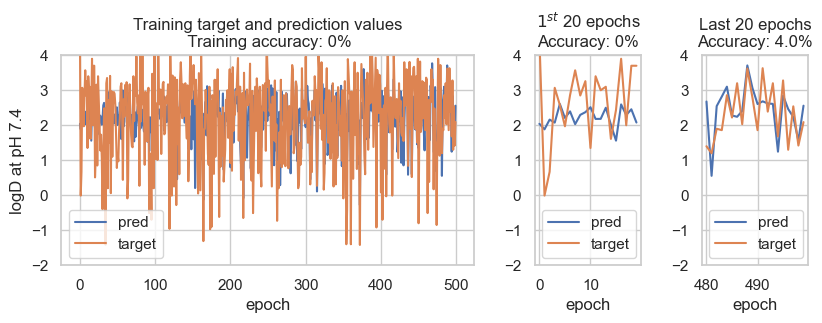

In [39]:
import matplotlib.pyplot as plt

# creating grid for subplots
fig = plt.figure(figsize=(10,6))
 
ax1 = plt.subplot2grid(shape=(2, 28), loc=(0,0), colspan=15)
ax2 = plt.subplot2grid(shape=(2, 28), loc=(0,17), colspan=4)
ax3 = plt.subplot2grid(shape=(2, 28), loc=(0,23), colspan=4)


results[[ 'pred', 'target']].plot(title='Training target and prediction values\n Training accuracy: ' + str(round(training_acc, 2) )+ '%',
                                  xlabel='epoch', ylabel = 'logD at pH 7.4', ax=ax1, ylim = (ymin, ymax) ) 
results[[ 'pred', 'target']][:20].plot(title="$1^{st}$ 20 epochs\nAccuracy: " + str(round(training_acc_1st_20, 2)) +'%',
                                       xlabel='epoch', ax=ax2, ylim = (ymin, ymax))
results[[ 'pred', 'target']][-20:].plot(title="Last 20 epochs\nAccuracy: " + str(round(training_acc_last_20, 2)) +'%',
                                       xlabel='epoch', ax=ax3, ylim = (ymin, ymax))
fig.savefig('assets/images/pred_vs_targ.png', bbox_inches='tight')

<div style="text-align:left;color:Maroon">
    <h4>More performance metrics.</h4>
</div>

<div style="text-align:left;color:Maroon">
    <h5>Plot RMSE (loss) and accuracy.</h5>
</div>
 

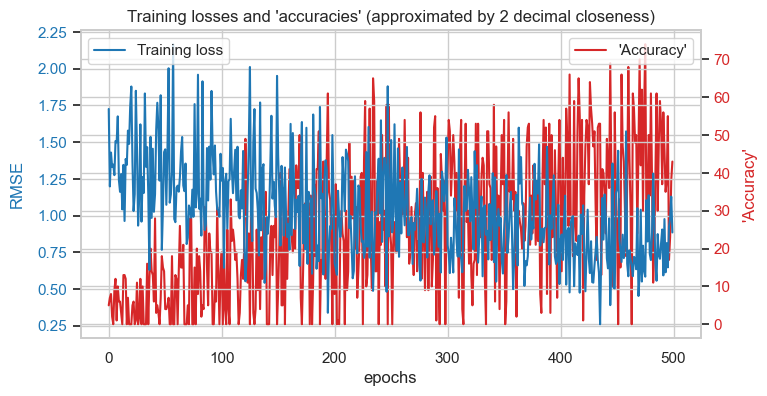

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(8,4))

color1 = 'tab:red'
ax1.set_xlabel('epochs')

ax1.tick_params(axis='y', labelcolor=color1)
sns.lineplot(data=results.accuracy, label="'Accuracy'", color=color1, ax=ax1)
plt.legend(loc='upper right')

ax2 = ax1.twinx() 

color2 = 'tab:blue'
ax1.set_ylabel('RMSE' , color=color2, labelpad=40)
ax2.set_ylabel("'Accuracy'", color=color1, labelpad=30)  

ax2.tick_params(axis='y', labelcolor=color2)
sns.lineplot(data=losses_float, label='Training loss', color=color2, ax=ax2)
plt.legend(loc='upper left')

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

plt.title("Training losses and 'accuracies' (approximated by 2 decimal closeness)")

plt.show()
fig.tight_layout()
fig.savefig('assets/images/losses_and_accuracies.png', bbox_inches='tight')

<div style="text-align:center;color:Blue">
    <h3> Evaluate model: use test data</h3>
</div>

#### Now that the model is fully trained, a test data prediction can be performed to probe accuracy.
##### A few plots are shown below to help training and testing accuracy progression

In [41]:
import pandas as pd 

# One batch prediction
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["real"] = df["y"].apply(lambda row: row[0])
df["pred"] = df["y_pred"].apply(lambda row: row[0])
df.head()

,y,y_pred,real,pred
0,[0.8799999952316284],[2.5868000984191895],0.88,2.586800
1,[1.399999976158142],[2.6121528148651123],1.40,2.612153
2,[2.259999990463257],[2.10548734664917],2.26,2.105487
3,[1.840000033378601],[2.3776063919067383],1.84,2.377606
4,[1.4900000095367432],[2.2606658935546875],1.49,2.260666


In [42]:
test_acc = r2_accuracy(df["real"], df["pred"])
test_acc_1st_20 = r2_accuracy(df["real"][:20], df["pred"][:20])

print("Test accuracy is {}%".format(round(test_acc, 2) ))
print("1st 20 test accuracy is {}%".format(round(test_acc_1st_20, 2)))

Test accuracy is 0%
1st 20 test accuracy is 0%


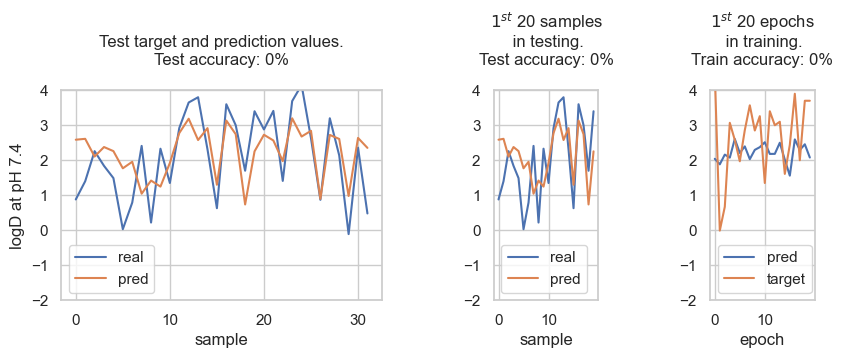

In [43]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,6))

ax1 = plt.subplot2grid(shape=(2, 36), loc=(0,0), colspan=15)
ax2 = plt.subplot2grid(shape=(2, 36), loc=(0,20), colspan=5)
ax3 = plt.subplot2grid(shape=(2, 36), loc=(0,30), colspan=5)

test_title = "Test target and prediction values." + "\nTest accuracy: {}%\n".format(round(test_acc, 2))
df[["real", "pred"]].plot(title=test_title, xlabel='sample', ylabel = 'logD at pH 7.4',
                          ax=ax1, ylim = (ymin, ymax) ) 

test_title_1st_20 = "$1^{st}$ 20 samples\n in testing." + "\nTest accuracy: {}%\n".format(round(test_acc_1st_20, 2))  
df[["real", "pred"]][:20].plot(title=test_title_1st_20, xlabel='sample',
                                       ax=ax2, ylim = (ymin, ymax))

train_title = "$1^{st}$ 20 epochs\n in training." + "\nTrain accuracy: {}%\n".format(round(training_acc_1st_20,2))  
results[[ 'pred', 'target']][:20].plot(title=train_title,
                                       xlabel='epoch',
                                 # ylabel = 'logD at pH 7.4',
                                       ax=ax3, ylim = (ymin, ymax))
fig.savefig('assets/images/pred_vs_targ_trained.png', bbox_inches='tight')

### TO DO:
#### Note the low test accuracy value, which as mentioned before, could be due to over training (the last 20 samples during training were predicted at 98% accuracy). Try larger data for testing, smaller data and epochs for training